In [42]:
import numpy as np
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

from tqdm import tqdm_notebook

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Unzipping the file from G-drive

In [8]:
dataset_path = "/content/drive/My Drive/cell_images (1).zip"

In [9]:
zip_object = zipfile.ZipFile(file=dataset_path, mode='r')

In [10]:
zip_object.extractall("./")

In [11]:
zip_object.close()

## Dataset Directory


In [12]:
data_dir = '/content/cell_images'

In [13]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(data_dir) 

['train', 'test']

In [16]:
test_path = data_dir+'//test//'
train_path = data_dir+'//train//'

In [17]:
os.listdir(test_path)

['uninfected', 'parasitized']

In [18]:
os.listdir(train_path)

['uninfected', 'parasitized']

In [19]:
os.listdir(train_path+'//parasitized')[0]

'C136P97ThinF_IMG_20151005_142627_cell_18.png'

## Image show

In [25]:
para_cell = train_path+'//parasitized'+'//C100P61ThinF_IMG_20150918_144104_cell_163.png'

In [26]:
para_img= imread(para_cell)

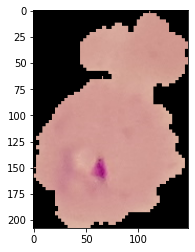

In [27]:
plt.imshow(para_img)

In [29]:
para_img.shape

(208, 148, 3)

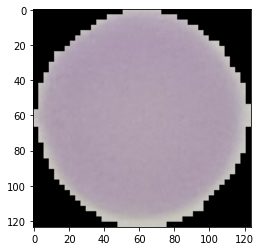

In [39]:
uninfected_cell_path = train_path+'//uninfected//'+os.listdir(train_path+'//uninfected')[10]
uninfected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

## Number of images in each folder

In [33]:
len(os.listdir(train_path+'//parasitized'))

12480

In [34]:
len(os.listdir(train_path+'//uninfected'))

12480

In [40]:
# Average dimension of these images
uninfected_cell.shape

(124, 124, 3)

In [41]:
para_img.shape

(208, 148, 3)

## Average dimension of these images
Because not all images will have same dimension

In [43]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'//uninfected'):
    
    img = imread(test_path+'//uninfected'+'//'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

In [45]:
#dim1
#dim2

In [46]:
np.mean(dim1)

130.92538461538462

In [47]:
np.mean(dim2)

130.75

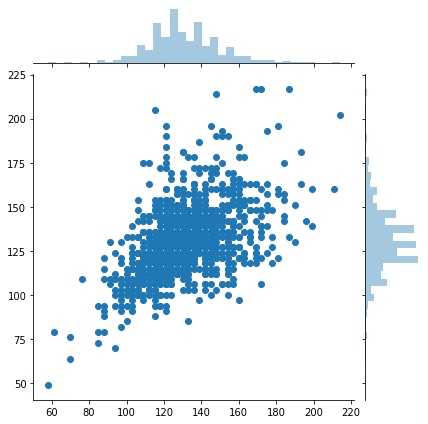

In [52]:
sns.jointplot(dim1, dim2)

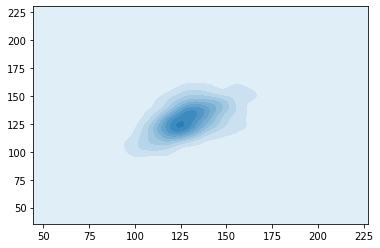

In [55]:
sns.kdeplot(dim1, dim2, shade=True, )

Let's take 130*130 avg size of the images

In [56]:
image_shape = (130,130,3)

## ImageDataGenerator

In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [59]:
#help(ImageDataGenerator)

In [61]:
uninfected_cell.max() # so no need to do rescaling

0.81960785

In [62]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

Random Generation of same image with the help of ImageDataGenerator

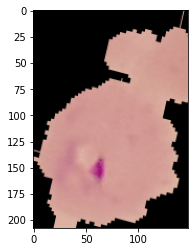

In [63]:
plt.imshow(image_gen.random_transform(para_img))

In [64]:
train_path

'/content/cell_images//train//'

In [65]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [66]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


## Creating the Model

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [68]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [76]:
# Early Stopping
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [71]:
image_shape[:2]

(130, 130)

In [72]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [73]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary',
                                               shuffle=False)

Found 2600 images belonging to 2 classes.


In [74]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

import warnings
warnings.filterwarnings('ignore')

to avoid deprecation warnings

In [78]:
results = model.fit(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                              callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 125s 80ms/step - loss: 0.1687 - accuracy: 0.9455 - val_loss: 0.2438 - val_accuracy: 0.9254
Epoch 2/20
1560/1560 [==============================] - 126s 81ms/step - loss: 0.1802 - accuracy: 0.9429 - val_loss: 0.1701 - val_accuracy: 0.9508
Epoch 3/20
1560/1560 [==============================] - 127s 81ms/step - loss: 0.1670 - accuracy: 0.9480 - val_loss: 0.2373 - val_accuracy: 0.9169
Epoch 4/20
1560/1560 [==============================] - 121s 78ms/step - loss: 0.1671 - accuracy: 0.9480 - val_loss: 0.1548 - val_accuracy: 0.9462
Epoch 5/20
1560/1560 [==============================] - 119s 76ms/step - loss: 0.1701 - accuracy: 0.9492 - val_loss: 0.1800 - val_accuracy: 0.9415
Epoch 6/20
1560/1560 [==============================] - 120s 77ms/step - loss: 0.1720 - accuracy: 0.9441 - val_loss: 0.1867 - val_accuracy: 0.9396


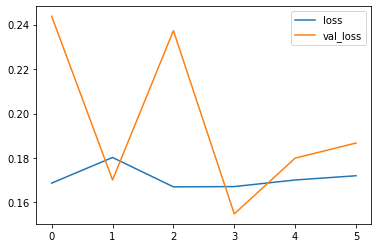

In [86]:
losses = pd.DataFrame(model.history.history)
losses[['loss', 'val_loss']].plot()

In [83]:
# To save the file which will be pre-trained model
from tensorflow.keras.models import load_model
model.save('malaria_detector.h5')

## Evaluating the model

In [87]:
y_pred = model.predict(test_image_gen)

In [88]:
y_pred = y_pred > 0.5

In [89]:
y_pred

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [90]:
from sklearn.metrics import confusion_matrix, classification_report

In [91]:
print(classification_report(test_image_gen.classes, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1300
           1       0.92      0.97      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



In [92]:
confusion_matrix(test_image_gen.classes, y_pred=y_pred)

array([[1192,  108],
       [  43, 1257]])

## New Predictions

In [93]:
para_cell

'/content/cell_images//train////parasitized//C100P61ThinF_IMG_20150918_144104_cell_163.png'

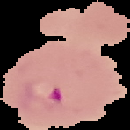

In [97]:
from keras.preprocessing import image
my_image = image.load_img(para_cell, target_size=image_shape)
my_image

In [98]:
my_image_arr = image.img_to_array(my_image)

In [100]:
my_image_arr.shape

(130, 130, 3)

In [101]:
# we need to define the shape as (1,130,130,3) so the model thinks we are providing batches of images even if it is one
my_image_arr = np.expand_dims(my_image_arr, axis=0)

In [103]:
my_image_arr.shape

(1, 130, 130, 3)

In [106]:
model.predict(my_image_arr)

array([[3.4737764e-06]], dtype=float32)

In [107]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

prediction for uninfected cell

In [115]:
uninfected_cell_new = os.listdir(train_path+'//uninfected')[55]

In [116]:
uninfected_cell_new

'C63P24N_ThinF_IMG_20150818_143319_cell_9.png'

In [118]:
uninfected_cell_new = train_path+'//uninfected'+'//C63P24N_ThinF_IMG_20150818_143319_cell_9.png'

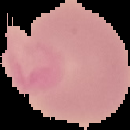

In [119]:
my_image_2 = image.load_img(uninfected_cell_new, target_size=image_shape)
my_image_2

In [120]:
my_image_arr_2 = image.img_to_array(my_image_2)

In [121]:
# we need to define the shape as (1,130,130,3) so the model thinks we are providing batches of images even if it is one
my_image_arr_2 = np.expand_dims(my_image_arr_2, axis=0)

In [122]:
my_image_arr_2.shape

(1, 130, 130, 3)

In [123]:
model.predict(my_image_arr_2)

array([[0.9927932]], dtype=float32)

In [124]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

## **Conclusion: The model performs very well!!**